<a href="https://colab.research.google.com/github/gatienc/multimodal_product_data_classification/blob/main/notebooks/gatien_fusion_model_clip0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Idea
### CLIP1:
In this version I am trying to use only image and designation, I'm applying
Explicit Cross-modal Interaction from 
[Hate-CLIPper: Multimodal Hateful Meme Classification based on Cross-modal Interaction of CLIP Features](https://arxiv.org/pdf/2210.05916.pdf)

### CLIP2: 
diff: added a dropout layer to reduce overfitting


### CLIP3: 
diff: if description exists, we get the mean of the features of description and designation

# Hyperparameters

In [36]:
BATCH_SIZE=128#  8 for 13.8 gb usage, 6 for less than 12 gb usage
NUM_CLASSES=27

CLIP_FEATURE_SIZE=768

#testing
# train_percentage=0.0001
# valid_percentage=0.0001

train_percentage=0.9
valid_percentage=0.1
#(test_percentage takes the rest)

google_colab=False
force_cpu=False
train=False

# Imports


In [37]:
%pip install transformers pandas tqdm scikit-learn imageio matplotlib wget plotly dash

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


In [38]:
from transformers import CLIPProcessor, CLIPModel,CLIPFeatureExtractor
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
from torch.optim import lr_scheduler
import torchvision

import imageio

from tqdm.notebook import tqdm
from sklearn.preprocessing import OneHotEncoder

from sklearn.metrics import f1_score

import zipfile
import os
import copy

import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

from datetime import datetime


In [39]:
%matplotlib inline

In [40]:
if google_colab:
  # mount the drive where your dataset is availabledevice = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  from google.colab import drive
  drive.mount('/content/drive')
  filepath='/content/drive/MyDrive/datasets/multimodal_product_classification/' # add your own path. Where to save the dataset

  if not os.path.exists('datasets'):
    os.makedirs('datasets')
    with zipfile.ZipFile(filepath+'images.zip', 'r') as zip_ref:
        zip_ref.extractall('datasets')
            
  datasets_path="/content/datasets/"
  save_directory="/content/drive/MyDrive/Lessons/Models/multimodal_classification/"

else:
  import wget
  if not os.path.exists('datasets'):
    os.makedirs('datasets')
    output_directory="datasets"
    csv_zip = wget.download("https://nextcloud.its-tps.fr/s/BTpB4SC93NreZxg/download/csv_data.zip",out=output_directory)
    images_zip=wget.download("https://nextcloud.its-tps.fr/s/fgBxQczEAZ7ws8J/download/images.zip",out=output_directory)
    
    with zipfile.ZipFile(output_directory+'/csv_data.zip', 'r') as zip_ref:
      zip_ref.extractall('datasets')
    with zipfile.ZipFile(output_directory+'/images.zip', 'r') as zip_ref:
        zip_ref.extractall('datasets')
  filepath=os.getcwd()+'/datasets/'
  save_directory='../models/'
  datasets_path=filepath
  

In [41]:
torch.cuda.empty_cache()
t = torch.cuda.get_device_properties(0).total_memory
print("total",t)
c = torch.cuda.memory_cached(0)
a = torch.cuda.memory_allocated(0)
f = c-a  # free inside cache
print("free inside cache",f)

total 15614476288
free inside cache 114470400


/opt/mamba/lib/python3.10/site-packages/torch/cuda/memory.py:444: FutureWarning:

torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved



In [42]:
if force_cpu:
    device = torch.device("cpu")
else:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# Preprocessing

In [43]:
# Load data
X_train = pd.read_csv(filepath+'X_train.csv').fillna("")
y_train = pd.read_csv(filepath+'Y_train.csv').fillna("")
X_train=X_train.drop(columns="Unnamed: 0")
y_train=y_train.drop(columns="Unnamed: 0")


In [44]:
description_len=[len(x) for x in X_train['description'].tolist()]

(array([7.4796e+04, 8.1160e+03, 1.3860e+03, 3.5100e+02, 1.6100e+02,
        6.5000e+01, 2.5000e+01, 1.3000e+01, 2.0000e+00, 1.0000e+00]),
 array([    0. ,  1245.1,  2490.2,  3735.3,  4980.4,  6225.5,  7470.6,
         8715.7,  9960.8, 11205.9, 12451. ]),
 <BarContainer object of 10 artists>)

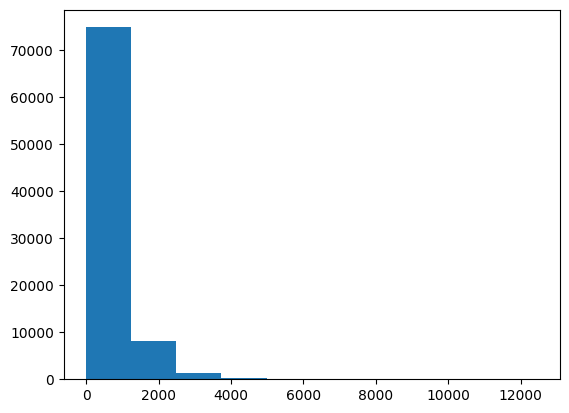

In [45]:
plt.hist(description_len)

Most of description have less than 4000 len,
maybe in the future  slice at 4000 for not too long tokenization

In [46]:
# Apply cleaning function to the 'designation' column
def clip_to_max_tokenize(text):
    text.split(" ",maxsplit=70)
    text=text[:70]
    text="".join(text)
    return(text)

X_train['designation'] = X_train['designation'].fillna('').apply(clip_to_max_tokenize)
X_train['description'] = X_train['description'].fillna('').apply(clip_to_max_tokenize)


plot a scatter plot of the representation in term of word as x number of word in designation and as y number of word in description.
if we see that sometimes x is low and y is big, we could fill designation with description

In [47]:
def get_number_of_token(text):
    """word != token but number will be approximately equal"""
    text.split(" ")
    return(len(text))


x=designation_list=X_train['designation'].apply(get_number_of_token).tolist()
y=description_list=X_train['description'].apply(get_number_of_token).tolist()
fig = px.density_heatmap(x=x, y=y)
fig.show()


In [48]:
encoded_df=pd.get_dummies(y_train, columns=['prdtypecode'])
y_train_categorical = encoded_df.values.tolist()


In [49]:
length=len(y_train_categorical)
y_train=pd.DataFrame(np.zeros((length,1),dtype=list),columns=["labels"])
for index,row in tqdm(enumerate(y_train_categorical)):
    y_train.loc[index, "labels"]=row
y_train

0it [00:00, ?it/s]

labels
0      [True, False, False, False, False, False, Fals...
1      [False, False, False, False, False, False, Fal...
2      [False, False, True, False, False, False, Fals...
3      [False, False, False, False, False, False, Fal...
4      [False, False, False, False, False, False, Fal...
...                                                  ...
84911  [False, True, False, False, False, False, Fals...
84912  [False, False, False, False, False, False, Fal...
84913  [False, False, False, False, False, False, Fal...
84914  [False, False, False, False, False, False, Fal...
84915  [False, False, False, False, False, False, Fal...

[84916 rows x 1 columns]

In [50]:
train_df=pd.concat([X_train,y_train],axis=1)

In [51]:
train_df

designation  \
0      Olivia: Personalisiertes Notizbuch / 150 Seite...   
1      Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...   
2      Grand Stylet Ergonomique Bleu Gamepad Nintendo...   
3      Peluche Donald - Europe - Disneyland 2000 (Mar...   
4                                   La Guerre Des Tuques   
...                                                  ...   
84911                        The Sims [ Import Anglais ]   
84912  Kit piscine acier NEVADA déco pierre Ø 3.50m x...   
84913  Journal Officiel De La Republique Francaise N°...   
84914  Table Basse Bois De Récupération Massif Base B...   
84915  Gomme De Collection 2 Gommes Pinguin Glace Ver...   

                                             description   productid  \
0                                                         3804725264   
1                                                          436067568   
2      PILOT STYLE Touch Pen de marque Speedlink est ...   201115110   
3                                                           50418756   
4      Luc a des id&eacute;es de grandeur. Il veut or...   278535884   
...                                                  ...         ...   
84911                                                      206719094   
84912  <b>Description complète :</b><br />Kit piscine...  3065095706   
84913                                                      440707564   
84914  <p>Cette table basse a un design unique et con...  3942400296   
84915                                                       57203227   

          imageid                                             labels  
0      1263597046  [True, False, False, False, False, False, Fals...  
1      1008141237  [False, False, False, False, False, False, Fal...  
2       938777978  [False, False, True, False, False, False, Fals...  
3       457047496  [False, False, False, False, False, False, Fal...  
4      1077757786  [False, False, False, False, False, False, Fal...  
...           ...                                                ...  
84911   941495734  [False, True, False, False, False, False, Fals...  
84912  1188462883  [False, False, False, False, False, False, Fal...  
84913  1009325617  [False, False, False, False, False, False, Fal...  
84914  1267353403  [False, False, False, False, False, False, Fal...  
84915   684671297  [False, False, False, False, False, False, Fal...  

[84916 rows x 5 columns]


# Data loading

In [52]:
def image_to_tensor(image):
    img=torch.from_numpy(image).float()
    out=img.permute(2,0,1)
    return(out)

In [53]:
class ImageTextDataLoader(Dataset):
    """Title, Description and Image dataset."""

    def __init__(self, dataframe, image_dir):
        """
        Arguments:
            csv_file (string): Path to the csv file with annotations.
            image_dir (string): Directory with all the images.
        """
        self.df = dataframe
        self.image_dir = image_dir

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        selected_df=self.df.iloc[idx]

        image_name="image_"+str(selected_df["imageid"])+"_product_"+str(selected_df["productid"])+".jpg"
        filepath=os.path.join(self.image_dir,image_name)
        image_arr = imageio.v3.imread(filepath)

        designation=selected_df['designation']
        description=selected_df['description']
        label=torch.tensor(selected_df['labels'], dtype=torch.float,device=device)

        return [designation,description,image_arr,label]


In [54]:
dataset=ImageTextDataLoader(train_df,datasets_path+"/images/image_train")



In [55]:
train_size = int(train_percentage * len(dataset))
valid_size = int(valid_percentage * len(dataset))
test_size = len(dataset) - train_size - valid_size

train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, valid_size, test_size])
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)


dataloaders={
    'train':train_dataloader,
    'val':valid_dataloader,
    'test':test_dataloader
    }


In [56]:
Clip_model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14").to(device)
Clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


OutOfMemoryError: CUDA out of memory. Tried to allocate 146.00 MiB. GPU 0 has a total capacty of 14.54 GiB of which 58.75 MiB is free. Process 1760089 has 14.47 GiB memory in use. Of the allocated memory 14.29 GiB is allocated by PyTorch, and 109.17 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
def get_images_features(images):
    inputs = Clip_processor(images=images, return_tensors="pt").to(device)
    image_features = Clip_model.get_image_features(**inputs).to(device)
    del inputs
    return(image_features)

def get_text_features(texts):
    inputs = Clip_processor(text=texts, padding=True, return_tensors="pt").to(device)
    text_features = Clip_model.get_text_features(**inputs).to(device)
    del inputs
    return(text_features)

# Model Definition

way 0 : concat the layer
way 1 (future): cross modal concatenation

In [ ]:
print(Clip_model.device)

cuda:0


In [ ]:
class ClassificationHead(nn.Module):
   def __init__(self, input_dim, num_classes):
       super(ClassificationHead, self).__init__()

       self.head=nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(input_dim,128),
            nn.ReLU(),
            nn.Linear(128,num_classes),
       )
       #self.softmax = nn.Softmax(dim=-1)

   def forward(self, x):
       x = self.head(x)
       return (x)


In [ ]:
model=ClassificationHead(CLIP_FEATURE_SIZE**2,NUM_CLASSES).to(device)

criterion = torch.nn.CrossEntropyLoss()

# All parameters are being optimized
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


In [ ]:
def calculate_weighted_f1_score(y_true, y_pred):
  return f1_score(y_true, y_pred, average='weighted')

In [ ]:
def plot_loss(train_losses,val_losses):
   # Update data
   with fig.batch_update():
    epoch_range=list(range(len(val_losses)))
    fig.data[0].x = epoch_range
    fig.data[0].y = train_losses
    fig.data[1].x = epoch_range
    fig.data[1].y = val_losses



In [ ]:

def train_model(model, criterion, optimizer, scheduler, num_epochs=15):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    epoch_losses = {'train': [], 'val': []}
    epoch_accs = {'train': [], 'val': []}
    epoch=0
    loop_on_epoch=tqdm(range(num_epochs),leave=False,position=0,ncols=800)
    for epoch in loop_on_epoch:
        loop_on_epoch.set_description("Train -> Loss: {:.4f} Acc: {:.4f} | Val -> {:.4f} Acc: {:.4f}".format(epoch_losses["train"][-1],epoch_accs["train"][-1],epoch_losses["val"][-1],epoch_accs["val"][-1])if epoch>=1 else "first epoch")
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train() # Set model to training mode
            else:
                model.eval() # Set model to evaluate mode

            running_loss = 0.0
            running_preds=np.array([])
            running_labels=np.array([])


            # Iterate over data.
            loop_on_batch=tqdm(dataloaders[phase],position=1,leave=False,ncols=800)
            for designation,description,image_arr,labels in loop_on_batch:
                designation = designation
                description = description

                description_features=[]


                with torch.no_grad():
                    for i in range(len(description)):
                        #get the description that are not null
                        if len(description[i])>=1:
                            description_feature=get_text_features(description[i].to(device))
                            description_features.append(description_feature[0])
                        else:
                            description_features.append([])
                    images_features=get_images_features(image_arr).unsqueeze(2)
                    designation_features=get_text_features(designation).unsqueeze(2)
                

                    if len(description_features[0])>0:
                        designation_features[0]=(designation_features[0]+description_features[0].unsqueeze(1))/2

                    #HERE implement fusion model of designation, description and image_arr
                    input_features=torch.matmul(images_features[0] , designation_features[0].T).flatten().to(device).unsqueeze(0)

                    for i in range(1,images_features.size(dim=0)):
                        # Perform the multiplication and append the result to the results array
                        if len(description_features[i])>0:
                            designation_features[i]=(designation_features[i]+description_features[i].unsqueeze(1))/2

                        feature_interaction_matrix=torch.matmul(images_features[i], designation_features[i].T)
                        input_feature=(feature_interaction_matrix).flatten().to(device)
                        input_features = torch.cat((input_features, input_feature.unsqueeze(0)), dim=0)


                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(input_features)
                    loss = criterion(preds, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                # statistics

                running_loss += loss.item() * len(designation)#batch size*actual loss
                running_batch_pred=np.argmax(preds.cpu().detach().numpy(),axis=1)
                running_batch_label=np.argmax(labels.data.cpu().numpy(),axis=1)
                running_preds=np.append(running_preds,running_batch_pred)
                running_labels=np.append(running_labels,running_batch_label)

                loop_on_batch.set_description('     {}| Loss: {:.4f}'.format(phase, loss.item()))


            #End of phase Epoch (train or validation)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc=calculate_weighted_f1_score(running_preds,running_labels)

            epoch_losses[phase]=np.append(epoch_losses[phase],epoch_loss)
            epoch_accs[phase]=np.append(epoch_accs[phase],epoch_acc)

            if phase == 'train':
                scheduler.step()

        #End of Epoch (train+validation epoch)
        plot_loss(epoch_losses["train"],epoch_losses["val"])#plot the loss at each epoch

        if epoch==10: #Unfreeze the model after the 10th epoch
            for param in model.parameters():
                param.requires_grad = True
        # deep copy the model
        if phase == 'val' and epoch_acc > best_acc:

            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), save_directory +'clip3-'+datetime.today().strftime('%Y-%m-%d-')+str(epoch)+'.ckpt')


    print('Best val Acc: {:4f}'.format(best_acc))
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, epoch_losses, epoch_accs

In [ ]:
fig = go.FigureWidget()

# Add traces
fig.add_scatter(x=[], y=[], mode='lines', name='Training Loss')
fig.add_scatter(x=[], y=[], mode='lines', name='Validation Loss')

# Set titles and labels
fig.layout.title="Training and Validation Loss"
# , xaxis_title="Epochs", yaxis_title="Loss")


fig

FigureWidget({
    'data': [{'mode': 'lines',
              'name': 'Training Loss',
              'type': 'scatter',
              'uid': '6b5d2d12-f664-446a-9bf7-d5e60fd6cd3e',
              'x': [],
              'y': []},
             {'mode': 'lines',
              'name': 'Validation Loss',
              'type': 'scatter',
              'uid': '4b99b212-1d30-4c8f-8284-50f50187dde3',
              'x': [],
              'y': []}],
    'layout': {'template': '...', 'title': {'text': 'Training and Validation Loss'}}
})

In [ ]:
 if train==True:
    train_model(model, criterion, optimizer,exp_lr_scheduler,num_epochs=15)

## eval on test(/eval) dataset

In [ ]:
# Load data
X_eval = pd.read_csv(filepath+'X_test.csv').fillna("")
X_eval=X_eval.drop(columns="Unnamed: 0")
X_eval['designation'] = X_eval['designation'].fillna('').apply(clip_to_max_tokenize)
X_eval['description'] = X_eval['description'].fillna('').apply(clip_to_max_tokenize)

X_eval["labels"]=np.zeros((len(X_eval["designation"]),1))

In [ ]:
eval_dataset=ImageTextDataLoader(X_eval,datasets_path+"/images/image_test")
print(len(eval_dataset))
eval_dataloader = DataLoader(eval_dataset, batch_size=BATCH_SIZE, shuffle=True)




13812


In [ ]:
saved_state_dict = torch.load("/home/onyxia/work/multimodal_product_data_classification/models/clip3-2024-01-15-5.ckpt")
model=ClassificationHead(CLIP_FEATURE_SIZE**2,NUM_CLASSES).to(device)
model.load_state_dict(saved_state_dict)
model.eval()
torch.no_grad()

In [ ]:

def eval_model(model,eval_dataloader):

    loop_on_batch=tqdm(eval_dataloader,leave=False,position=0,ncols=800)
    preds=[]
    for batch in loop_on_batch:
        # print(batch)
        designation,description,image_arr,_=batch

        # Iterate over data.
        description_features=[]

        for i in range(len(description)):
            #get the description that are not null
            if len(description[i])>=1:
                # print(f'{description[i]=}')
                description_feature=get_text_features(description[i])
                description_features.append(description_feature[0])
            else:
                description_features.append([])
        images_features=get_images_features(image_arr).unsqueeze(2)
        designation_features=get_text_features(designation).unsqueeze(2)
            

        if len(description_features[0])>0:
            designation_features[0]=(designation_features[0]+description_features[0].unsqueeze(1))/2

        #HERE implement fusion model of designation, description and image_arr
        input_features=torch.matmul(images_features[0] , designation_features[0].T).flatten().to(device).unsqueeze(0)

        for i in range(1,images_features.size(dim=0)):
            # Perform the multiplication and append the result to the results array
            if len(description_features[i])>0:
                designation_features[i]=(designation_features[i]+description_features[i].unsqueeze(1))/2

            feature_interaction_matrix=torch.matmul(images_features[i], designation_features[i].T)
            input_feature=(feature_interaction_matrix).flatten().to(device)
            input_features = torch.cat((input_features, input_feature.unsqueeze(0)), dim=0)

        # forward
        pred=model(input_features)
        print(pred)
        preds.append(pred)


    return preds

In [ ]:
preds=eval_model(model,eval_dataloader)

  0%|                                                                                                         …

OutOfMemoryError: CUDA out of memory. Tried to allocate 518.00 MiB. GPU 0 has a total capacty of 14.54 GiB of which 58.75 MiB is free. Process 1760089 has 14.47 GiB memory in use. Of the allocated memory 14.29 GiB is allocated by PyTorch, and 109.17 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
df_preds=pd.DataFrame(preds)
df_preds.to_csv("/home/onyxia/work/multimodal_product_data_classification/df_preds.csv")
